In [26]:
import numpy as np
import keras
import os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras import models
from keras import layers
from keras import optimizers
import cv2
import random
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from keras import metrics
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import backend as K

###Data Loading and Pre-Processing.

In [75]:
# a)Load BreastMNIST data (Upload it to the drive)
breast_data = np.load('breastmnist.npz')
# Training
X_breast_train, y_breast_train = breast_data["train_images"], breast_data["train_labels"]
# Validation
X_breast_val, y_breast_val = breast_data["val_images"], breast_data["val_labels"]
# Testing
X_breast_test, y_breast_test = breast_data["test_images"], breast_data["test_labels"]

X_resnet_train, y_resnet_train = breast_data["train_images"], breast_data["train_labels"]
X_resnet_val, y_resnet_val = breast_data["val_images"], breast_data["val_labels"]
X_resnet_test, y_resnet_test = breast_data["test_images"], breast_data["test_labels"]

In [4]:
# a)Check no records are missing
print('Training: no. images: {}, no. labels: {}'.format(len(breast_data['train_images']), len(breast_data['train_labels'])))
print('Validation: no. images: {}, no. labels: {}'.format(len(breast_data['val_images']), len(breast_data['val_labels'])))
print('Testing: no. images: {}, no. labels: {}'.format(len(breast_data['test_images']), len(breast_data['test_labels'])))

Training: no. images: 546, no. labels: 546
Validation: no. images: 78, no. labels: 78
Testing: no. images: 156, no. labels: 156


###Normalizing and Formatting the Data

In [5]:
# b)Normalize the images
X_breast_train = X_breast_train / 255.0
X_breast_test = X_breast_test / 255.0
X_breast_val = X_breast_val / 255.0
# b)Reshape the images
X_breast_train = np.reshape(X_breast_train, (X_breast_train.shape[0], 28, 28, 1))
X_breast_test = np.reshape(X_breast_test, (X_breast_test.shape[0], 28, 28, 1))
X_breast_val = np.reshape(X_breast_val, (X_breast_val.shape[0], 28, 28, 1))

###Visualisation

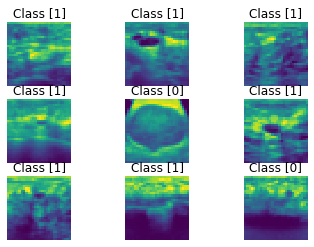

In [13]:
# c)Visualise a subset of the training data and ground truth
import matplotlib.pyplot as plt
breastmnist_classes = {'0': 'malignant', '1': 'normal/benign'}
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_breast_train[i], interpolation='none')
    plt.title("Class {}".format(y_breast_train[i]))
    plt.axis('off')

###Performing Data Augmentation aiming to improve the Overall Performance.

In [53]:
# d) Perform data augmentation
augmentation = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='nearest'
        )
# d) Fit the datagen on the training data
augmentation.fit(X_breast_train)

###Performing Train_test_split

In [18]:
# e) Combine the training and validation sets into a single training set before sending them to train_test_split
X_breast_train1 = np.concatenate((X_breast_train, X_breast_val))
y_breast_train1 = np.concatenate((y_breast_train, y_breast_val))

In [21]:
# e) Split the combined training set into a new training set(80%) and a testing set(20%)
X_trainb, X_testb, y_trainb, y_testb = train_test_split(X_breast_train1, y_breast_train1, test_size=0.2, random_state=42)

###Distribution of data across the class

In [22]:
# Training
print('Training')
vals, counts = np.unique(y_breast_train, return_counts=True)
train_counts = dict(zip(vals, counts))
print(train_counts)
train_percentages = dict(zip(vals, np.round(counts*100/len(y_breast_train),2)))
print(train_percentages)
# Validation
print('Validation')
vals, counts = np.unique(y_breast_val, return_counts=True)
val_counts = dict(zip(vals, counts))
print(val_counts)
val_percentages = dict(zip(vals, np.round(counts*100/len(y_breast_val),2)))
print(val_percentages)
# Testing
print('Testing')
vals, counts = np.unique(y_breast_test, return_counts=True)
test_counts = dict(zip(vals, counts))
print(test_counts)
test_percentages = dict(zip(vals, np.round(counts*100/len(y_breast_test),2)))
print(test_percentages)
# Overall
print('Overall')
y_all = np.concatenate([y_breast_train, y_breast_val, y_breast_test], axis=0)
vals, counts = np.unique(y_all, return_counts=True)
all_counts = dict(zip(vals, counts))
print(all_counts)
all_percentages = dict(zip(vals, np.round(counts*100/len(y_all),2)))
print(all_percentages)

Training
{0: 147, 1: 399}
{0: 26.92, 1: 73.08}
Validation
{0: 21, 1: 57}
{0: 26.92, 1: 73.08}
Testing
{0: 42, 1: 114}
{0: 26.92, 1: 73.08}
Overall
{0: 210, 1: 570}
{0: 26.92, 1: 73.08}


We have an imbalanced data which is handled using SMOTE(Synthetic Minority Over-sampling Technique) method below.

In [23]:
# Apply SMOTE to the training data
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_breast_train_resampled, y_breast_train_resampled = sm.fit_resample(X_trainb.reshape(X_trainb.shape[0], -1), y_trainb)
X_breast_train_resampled = X_breast_train_resampled.reshape(X_breast_train_resampled.shape[0], X_trainb.shape[1], X_trainb.shape[2], 1)

In [24]:
# Check class distribution of training set after oversampling
print("Class distribution after oversampling:")
unique, counts = np.unique(y_breast_train_resampled, return_counts=True)
print(dict(zip(unique, counts)))

Class distribution after oversampling:
{0: 372, 1: 372}


###Training CNN Model for BreastMNIST dataset

In [28]:
# Define custom metrics
# https://datascience.stackexchange.com/questions/105101/which-keras-metric-for-multiclass-classification
# Include an epsilon term in the denominators to avoid potential divide-by-zero errors: https://www.tensorflow.org/api_docs/python/tf/keras/backend/epsilon

# Recall
def recall_m(y_true, y_pred):
  TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = TP / (Positives+K.epsilon())
  return recall

# Precision
def precision_m(y_true, y_pred):
  TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = TP / (Pred_Positives+K.epsilon())
  return precision

# F1 Score
def f1_m(y_true, y_pred):    
  precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)  
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [29]:
# Common training parameters
IMG_SIZE = 224
num_classes = 8
# Function to plot the training accuracy, validation accuracy, training loss, and validation loss
def plot_training_history(training_history):
  # Get training and validation accuracy histories
  training_accuracy = training_history.history["accuracy"]
  val_accuracy = training_history.history["accuracy"]
  # Get training and validation loss histories
  training_loss = training_history.history["loss"]
  val_loss = training_history.history["val_loss"]
  # Create count of the number of epochs
  epoch_count = range(1, len(training_loss) + 1)
  fig, ax = plt.subplots(1, 2, figsize=(15, 6))
  # Visualise accuracy history
  ax[0].plot(epoch_count, training_accuracy, "r--")
  ax[0].plot(epoch_count, val_accuracy, "b--")
  ax[0].legend(["Training Accuracy", "Validation Accuracy"])
  ax[0].set_xlabel("Epoch")
  ax[0].set_ylabel("Accuracy")
  # Visualise loss history
  ax[1].plot(epoch_count, training_loss, "r--")
  ax[1].plot(epoch_count, val_loss, "b--")
  ax[1].legend(["Training Loss", "Validation Loss"])
  ax[1].set_xlabel("Epoch")
  ax[1].set_ylabel("Loss")
  # Show the plot
  plt.show()

In [41]:
# Function to display metrics and confusion matrix for a given model
def evaluate_model_performance(model):
  # Evaluate model
  scores = model.evaluate(X_breast_test, y_breast_test)

  # Print out all metrics
  print('')
  print('Metrics')
  for i in range(len(model.metrics_names)):
    print('{}: {}'.format(model.metrics_names[i], np.round(scores[i], 4)))
  print('')
  
  # Predict classes for test data
  y_pred = model.predict(X_breast_test)
  y_pred_classes = np.argmax(y_pred, axis=1) # The class for each sample is the one with the highest probability

  # Plot confusion matrix
  #fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
  #ConfusionMatrixDisplay.from_predictions(y_breast_test, y_pred_classes, normalize='pred', ax=axes, cmap=plt.cm.Blues)
  #plt.show()

In [27]:
# f) Define the CNN architecture
CNN_breast_model = Sequential()
CNN_breast_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
CNN_breast_model.add(MaxPooling2D((2, 2)))
CNN_breast_model.add(Conv2D(64, (3, 3), activation='relu'))
CNN_breast_model.add(MaxPooling2D((2, 2)))
CNN_breast_model.add(Flatten())
CNN_breast_model.add(Dense(64, activation='relu'))
CNN_breast_model.add(Dropout(0.5))
CNN_breast_model.add(Dense(1, activation='sigmoid'))

In [87]:
# Save the model in HDF5 format
CNN_breast_model.save('breast_cnn_final.h5')

In [31]:
# f) Compile the model
CNN_breast_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision_m, recall_m, f1_m])

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [62]:
# f) Train the model with imbalanced data
history = CNN_breast_model.fit(augmentation.flow(X_breast_train, y_breast_train, batch_size=32), 
                    epochs=20, 
                    validation_data=(X_breast_val, y_breast_val))

Epoch 1/20
18/18 [==============================] - 3s 176ms/step - loss: 0.4136 - accuracy: 0.8205 - precision_m: 0.7992 - recall_m: 0.8781 - f1_m: 0.8347 - val_loss: 0.3850 - val_accuracy: 0.8590 - val_precision_m: 0.8517 - val_recall_m: 1.0000 - val_f1_m: 0.9193
Epoch 2/20
18/18 [==============================] - 2s 83ms/step - loss: 0.3817 - accuracy: 0.8315 - precision_m: 0.8542 - recall_m: 0.9309 - f1_m: 0.8902 - val_loss: 0.3857 - val_accuracy: 0.8590 - val_precision_m: 0.8517 - val_recall_m: 1.0000 - val_f1_m: 0.9193
Epoch 3/20
18/18 [==============================] - 1s 45ms/step - loss: 0.3937 - accuracy: 0.8388 - precision_m: 0.8564 - recall_m: 0.9523 - f1_m: 0.9001 - val_loss: 0.3865 - val_accuracy: 0.8590 - val_precision_m: 0.8517 - val_recall_m: 1.0000 - val_f1_m: 0.9193
Epoch 4/20
18/18 [==============================] - 1s 42ms/step - loss: 0.4054 - accuracy: 0.8315 - precision_m: 0.8518 - recall_m: 0.9421 - f1_m: 0.8919 - val_loss: 0.3866 - val_accuracy: 0.8590 - val_p

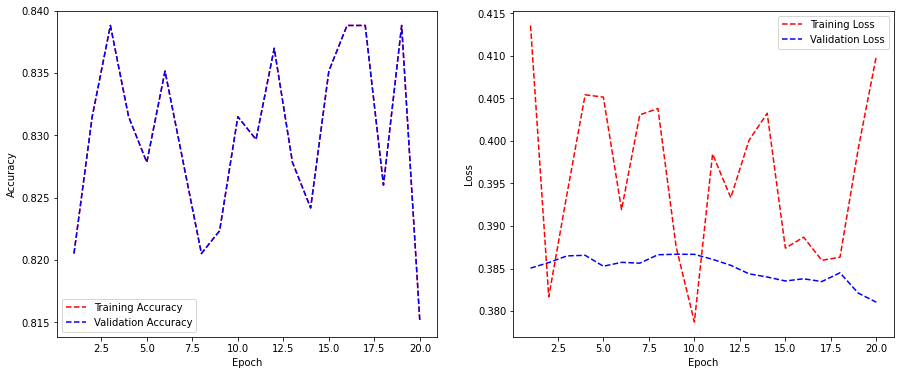

In [63]:
plot_training_history(history)

In [64]:
evaluate_model_performance(CNN_breast_model)

5/5 [==============================] - 0s 21ms/step - loss: 0.4364 - accuracy: 0.8205 - precision_m: 0.8097 - recall_m: 0.9833 - f1_m: 0.8870

Metrics
loss: 0.4364
accuracy: 0.8205
precision_m: 0.8097
recall_m: 0.9833
f1_m: 0.887

5/5 [==============================] - 0s 20ms/step


###CNN Model after SMOTE.

In [65]:
# Train the model after SMOTE( After handling imbalanced data)
history2 = CNN_breast_model.fit(augmentation.flow(X_breast_train_resampled, y_breast_train_resampled, batch_size=32), 
                    epochs=20, 
                    validation_data=(X_breast_val, y_breast_val))

Epoch 1/20
24/24 [==============================] - 2s 78ms/step - loss: 0.4110 - accuracy: 0.8242 - precision_m: 0.7679 - recall_m: 0.9372 - f1_m: 0.8400 - val_loss: 0.3748 - val_accuracy: 0.8590 - val_precision_m: 0.8517 - val_recall_m: 1.0000 - val_f1_m: 0.9193
Epoch 2/20
24/24 [==============================] - 1s 47ms/step - loss: 0.4067 - accuracy: 0.8164 - precision_m: 0.7599 - recall_m: 0.9251 - f1_m: 0.8305 - val_loss: 0.3688 - val_accuracy: 0.8590 - val_precision_m: 0.8517 - val_recall_m: 1.0000 - val_f1_m: 0.9193
Epoch 3/20
24/24 [==============================] - 1s 44ms/step - loss: 0.3892 - accuracy: 0.8307 - precision_m: 0.7738 - recall_m: 0.9331 - f1_m: 0.8417 - val_loss: 0.3635 - val_accuracy: 0.8590 - val_precision_m: 0.8517 - val_recall_m: 1.0000 - val_f1_m: 0.9193
Epoch 4/20
24/24 [==============================] - 1s 43ms/step - loss: 0.3989 - accuracy: 0.8281 - precision_m: 0.7658 - recall_m: 0.9481 - f1_m: 0.8433 - val_loss: 0.3587 - val_accuracy: 0.8590 - val_pr

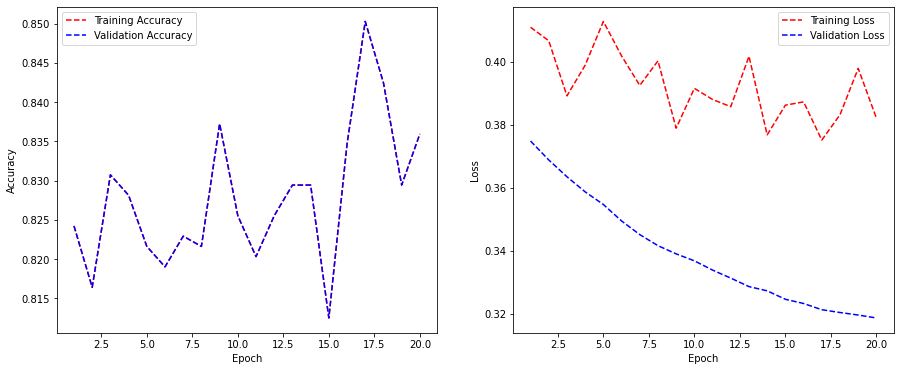

In [66]:
plot_training_history(history2)

In [67]:
CNN_breast_model.evaluate(X_testb, y_testb)

4/4 [==============================] - 0s 10ms/step - loss: 0.4651 - accuracy: 0.8000 - precision_m: 0.7798 - recall_m: 0.9757 - f1_m: 0.8636


[0.46509629487991333,
 0.800000011920929,
 0.7798382043838501,
 0.9756786823272705,
 0.8635506629943848]

In [70]:
yp = CNN_breast_model.predict(X_testb)
yp[:5]

4/4 [==============================] - 0s 10ms/step


array([[0.91557926],
       [0.03847659],
       [0.8262877 ],
       [0.66340727],
       [0.9629078 ]], dtype=float32)

In [71]:
y_pred = []
for element in yp:
    if element > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [72]:
y_pred[:10]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1]

In [73]:
y_testb[:10]

array([[0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1]], dtype=uint8)

###Resnet model for BreastMnist dataset

In [76]:
from PIL import Image

X_train_rgb = np.stack((X_resnet_train,) * 3, axis=-1)  # convert to RGB format
X_train_resized = np.zeros((X_resnet_train.shape[0], 224, 224, 3))  # initialize resized array

for i in range(X_resnet_train.shape[0]):
    img = Image.fromarray(X_train_rgb[i].astype('uint8'), mode='RGB')
    img_resized = img.resize((224, 224), resample=Image.BICUBIC)
    X_train_resized[i] = np.array(img_resized)

X_train_normalized = X_train_resized.astype('float32') / 255.0  # normalize pixel values

X_test_rgb = np.stack((X_resnet_test,) * 3, axis=-1)  # convert to RGB format
X_test_resized = np.zeros((X_resnet_test.shape[0], 224, 224, 3))  # initialize resized array

for i in range(X_resnet_test.shape[0]):
    img = Image.fromarray(X_test_rgb[i].astype('uint8'), mode='RGB')
    img_resized = img.resize((224, 224), resample=Image.BICUBIC)
    X_test_resized[i] = np.array(img_resized)

X_test_normalized = X_test_resized.astype('float32') / 255.0  # normalize pixel values

In [78]:
from keras.utils import to_categorical

y_resnet_train = to_categorical(y_resnet_train)
y_resnet_test = to_categorical(y_resnet_test)

In [81]:
# reshape the input data
X_resnet_train = np.expand_dims(X_resnet_train, axis=-1)
X_resnet_test = np.expand_dims(X_resnet_test, axis=-1)

# verify the new shape
print(X_resnet_train.shape) # (546, 28, 28, 1)
print(X_resnet_test.shape) # (182, 28, 28, 1)

(546, 28, 28, 1, 1)
(156, 28, 28, 1, 1)


In [82]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

num_classes = 2  # binary classification

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

resnet_model = Model(inputs=base_model.input, outputs=predictions)

94765736/94765736 [==============================] - 1s 0us/step


In [86]:
from tensorflow.keras.optimizers import SGD

resnet_model.compile(optimizer=SGD(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history= resnet_model.fit(X_train_normalized, y_resnet_train, batch_size=32, epochs=10, validation_data=(X_test_normalized, y_resnet_test))

Epoch 1/10
 4/18 [=====>........................] - ETA: 7:08 - loss: 0.1829 - accuracy: 0.9766

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt

# plot loss curve
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# plot accuracy curve
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [ ]:
# Evaluate the model on the test data
test_loss, test_acc = resnet_model.evaluate(X_test_resized, y_resnet_test)
print('Test accuracy:', test_acc)

In [ ]:
# Extract unique labels from train and test sets
train_labels_unique = np.unique(y_resnet_train)
test_labels_unique = np.unique(y_resnet_test)

# Concatenate unique labels and sort them
class_names = np.concatenate((train_labels_unique, test_labels_unique))
class_names = np.sort(np.unique(class_names))

print(class_names)

In [ ]:
# convert y_pred to one-hot encoding
y_pred_onehot = np.zeros_like(y_resnet_test)
y_pred_onehot[np.arange(len(y_resnet_test)), y_pred] = 1

# calculate evaluation metrics
report = classification_report(y_resnet_test, y_pred_onehot, target_names=class_names, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']
accuracy = np.mean(y_pred == y_resnet_test)
print(precision)
print(recall)
print(f1_score)
